# Using all words in the vocabulary

In [1]:
from tensorflow.keras.datasets import reuters
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [6]:
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/reuters_word_index.json

import json

with open('reuters_word_index.json', 'r', encoding='utf-8') as f:
    word_index = json.load(f)

print('=3')

--2025-09-01 05:13:40--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/reuters_word_index.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 550378 (537K) [application/json]
Saving to: ‘reuters_word_index.json’

reuters_word_index. 100%[===================>] 537.48K  --.-KB/s    in 0.003s  

2025-09-01 05:13:40 (151 MB/s) - ‘reuters_word_index.json’ saved [550378/550378]

=3


In [3]:
index_to_word={index+3:word for word, index in word_index.items()}

In [4]:
for index, token in enumerate(('<pad>','<sos>', '<unk>')):
  index_to_word[index]=token

In [5]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [6]:
decoded=[]
for i in range(len(x_train)):
  t=' '.join([index_to_word[index] for index in x_train[i]])
  decoded.append(t)

x_train=decoded

In [7]:
decoded=[]
for i in range(len(x_test)):
  t=' '.join([index_to_word[index] for index in x_test[i]])
  decoded.append(t)

x_test=decoded

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [9]:
dtmvector= CountVectorizer()
x_train_dtm=dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


In [10]:
tfidf_transformer=TfidfTransformer()
tfidfv=tfidf_transformer.fit_transform(x_train_dtm)

In [11]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

In [15]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

In [16]:
from xgboost import XGBClassifier
models_dict={
    'MNB': MultinomialNB(),
    'CNB': ComplementNB(),
    'LogReg': LogisticRegression(max_iter=2000, penalty='l2'),
    'LinearSVC': LinearSVC(),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(n_estimators=5),
    'XGBoost': XGBClassifier(
        tree_method="hist",
        device="cuda",
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="mlogloss",
        use_label_encoder=False
    )
}

voting=VotingClassifier(estimators=[
    ('lr', LogisticRegression(max_iter=2000, penalty='l2')),
    ('mnb', MultinomialNB()),
    ('rf', RandomForestClassifier(n_estimators=300))
], voting='soft', n_jobs=-1)

models_dict['Voting']= voting

In [21]:
from sklearn.metrics import f1_score, accuracy_score
results=[]

for name, model in models_dict.items():
  model.fit(tfidfv, y_train)
  predicted=model.predict(tfidfv_test)

  acc=accuracy_score(y_test, predicted)
  f1=f1_score(y_test, predicted, average='macro')

  results.append({'model': name, 'accuracy': acc, 'f1': f1})
  print(f'{name} Accuracy: {acc:.3f}, F1: {f1:.3f}')

MNB Accuracy: 0.600, F1: 0.068
CNB Accuracy: 0.765, F1: 0.464
LogReg Accuracy: 0.792, F1: 0.451
LinearSVC Accuracy: 0.829, F1: 0.689
DecisionTree Accuracy: 0.699, F1: 0.463
RandomForest Accuracy: 0.672, F1: 0.305


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:47:05] WARNING: /workspace/src/common/error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:47:05] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [03:47:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.818, F1: 0.666


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:2676: UserWarning: [03:48:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [03:48:29] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Voting Accuracy: 0.703, F1: 0.260


In [22]:
import pandas as pd

results_all=pd.DataFrame(results)
results_all

,model,accuracy,f1
0,MNB,0.599733,0.067679
1,CNB,0.764915,0.463985
2,LogReg,0.791630,0.451397
3,LinearSVC,0.829475,0.688698
4,DecisionTree,0.699020,0.463008
5,RandomForest,0.671861,0.305431
6,XGBoost,0.818344,0.665850
7,Voting,0.703473,0.260246


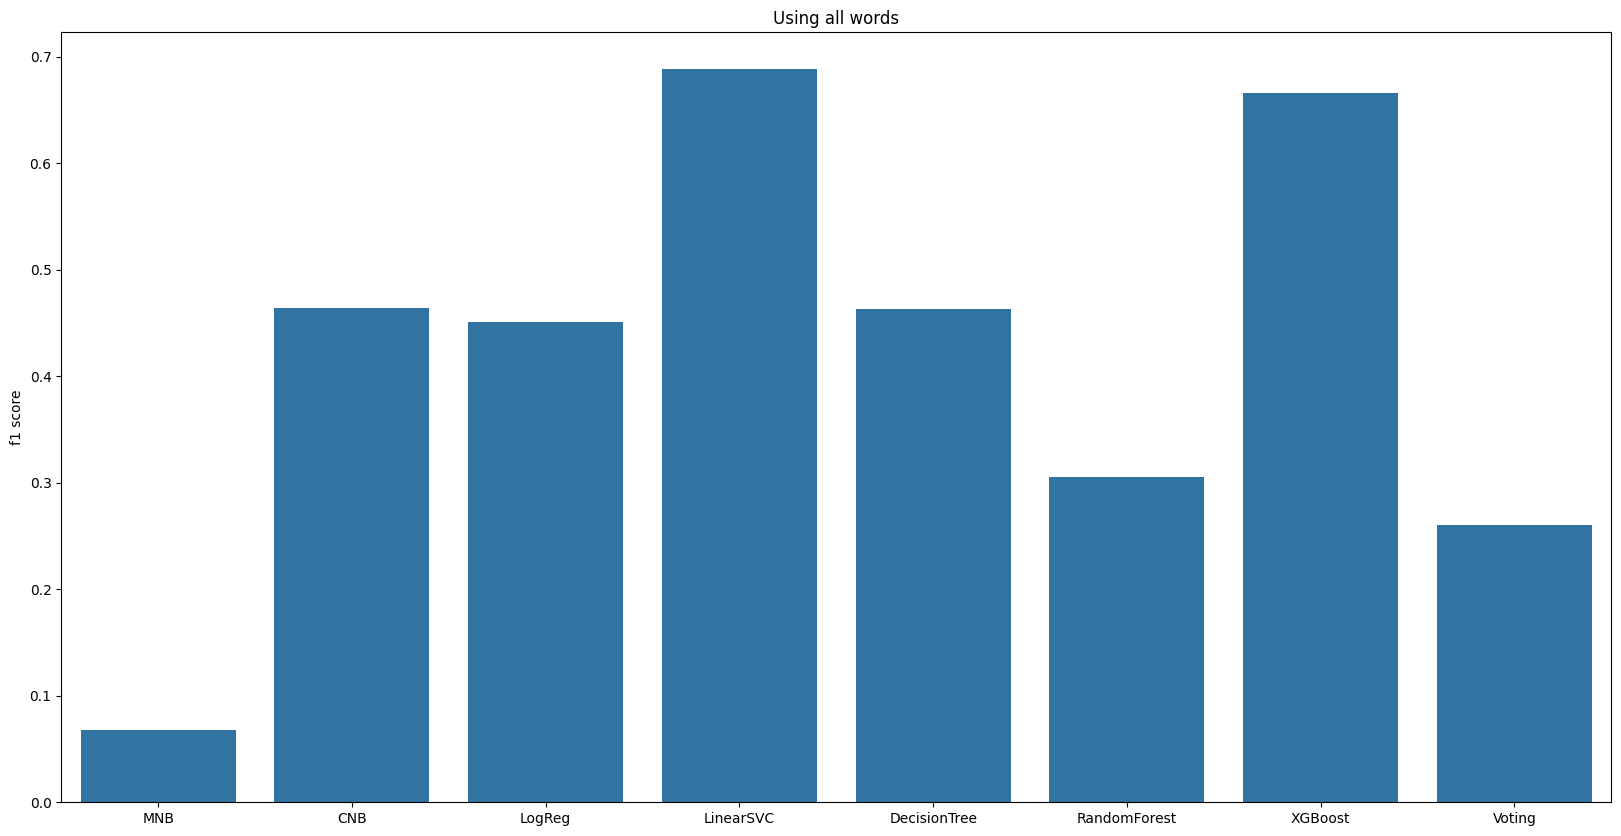

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
sns.barplot(x=results_all['model'].values, y=results_all['f1'].values)
plt.title('Using all words')
plt.ylabel('f1 score')
plt.show()

In [37]:
from sklearn.metrics import confusion_matrix
def graph_confusion_matrix(model, x_test, y_test):
  df_cm=pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))
  fig=plt.figure(figsize=(12,12))
  heatmap=sns.heatmap(df_cm, annot=True, fmt="d")
  heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
  heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
  plt.title(f'{model} confusion matrix')
  plt.ylabel('label')
  plt.xlabel('predicted value')

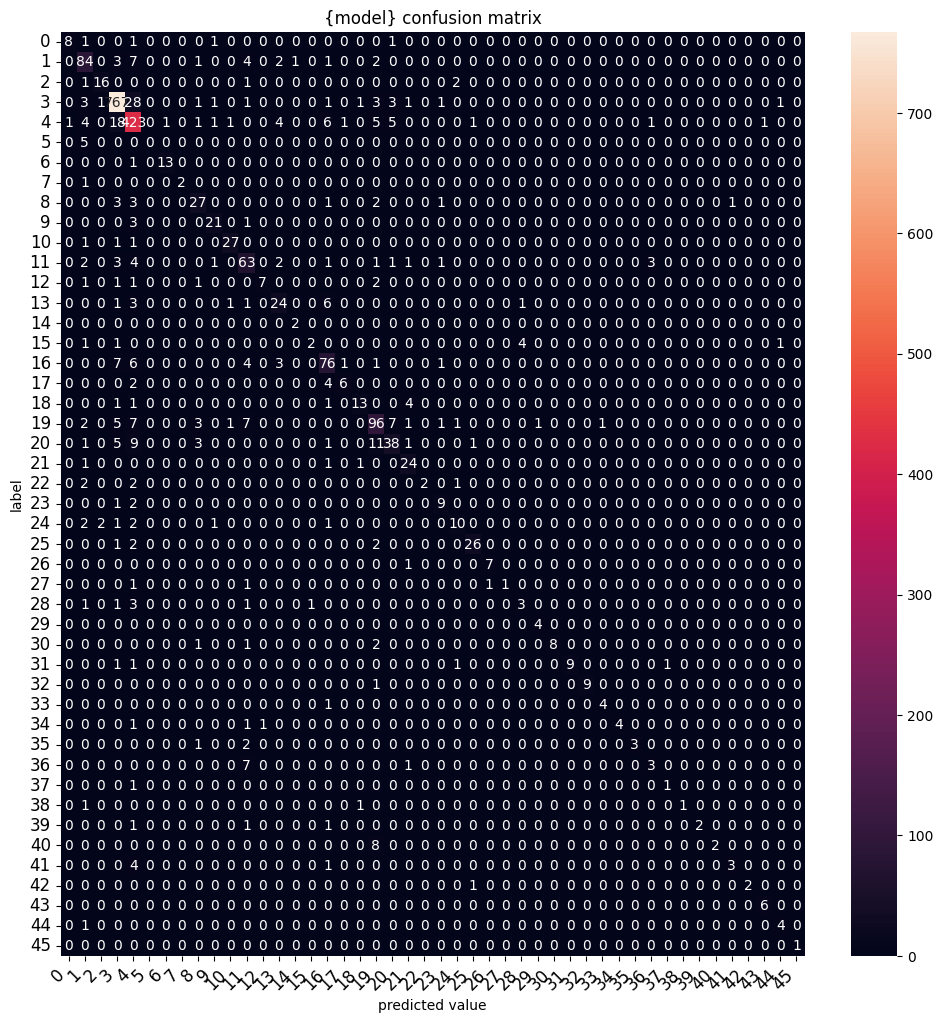

In [30]:
graph_confusion_matrix(models_dict['LinearSVC'], tfidfv_test, y_test)

# Using only 5000 words in the vocabulary

In [4]:
from tensorflow.keras.datasets import reuters
(x_train, y_train), (x_test, y_test)= reuters.load_data(num_words=5000, test_split=0.2)

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
index_to_word={index+3: word for word, index in word_index.items()}

for index, token in enumerate(('<pad>','<sos>', '<unk>')):
  index_to_word[index]=token

In [8]:
decoded=[]
for i in range(len(x_train)):
  t=' '.join([index_to_word[index] for index in x_train[i]])
  decoded.append(t)

x_train=decoded

In [9]:
decoded=[]
for i in range(len(x_test)):
  t=' '.join([index_to_word[index] for index in x_test[i]])
  decoded.append(t)

x_test=decoded

In [12]:
dtmvector= CountVectorizer()
x_train_dtm=dtmvector.fit_transform(x_train)
tfidf_transformer=TfidfTransformer()
tfidfv=tfidf_transformer.fit_transform(x_train_dtm)
x_test_dtm = dtmvector.transform(x_test)
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

In [19]:
from sklearn.metrics import f1_score, accuracy_score
results=[]
for name, model in models_dict.items():
  model.fit(tfidfv, y_train)
  predicted=model.predict(tfidfv_test)

  acc=accuracy_score(y_test, predicted)
  f1=f1_score(y_test, predicted, average='macro')

  results.append({'model': name, 'accuracy': acc, 'f1': f1})
  print(f'{name} Accuracy: {acc:.3f}, F1: {f1:.3f}')

MNB Accuracy: 0.673, F1: 0.110
CNB Accuracy: 0.771, F1: 0.482
LogReg Accuracy: 0.798, F1: 0.481
LinearSVC Accuracy: 0.829, F1: 0.681
DecisionTree Accuracy: 0.692, F1: 0.445
RandomForest Accuracy: 0.683, F1: 0.315


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:16:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.814, F1: 0.655


/usr/local/lib/python3.12/dist-packages/xgboost/core.py:729: UserWarning: [05:17:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


Voting Accuracy: 0.752, F1: 0.328


In [20]:
results_5000=pd.DataFrame(results)
results_5000

,model,accuracy,f1
0,MNB,0.673197,0.110173
1,CNB,0.770703,0.482035
2,LogReg,0.797863,0.481380
3,LinearSVC,0.829029,0.681414
4,DecisionTree,0.691897,0.444742
5,RandomForest,0.683437,0.315275
6,XGBoost,0.813891,0.655484
7,Voting,0.751558,0.328096


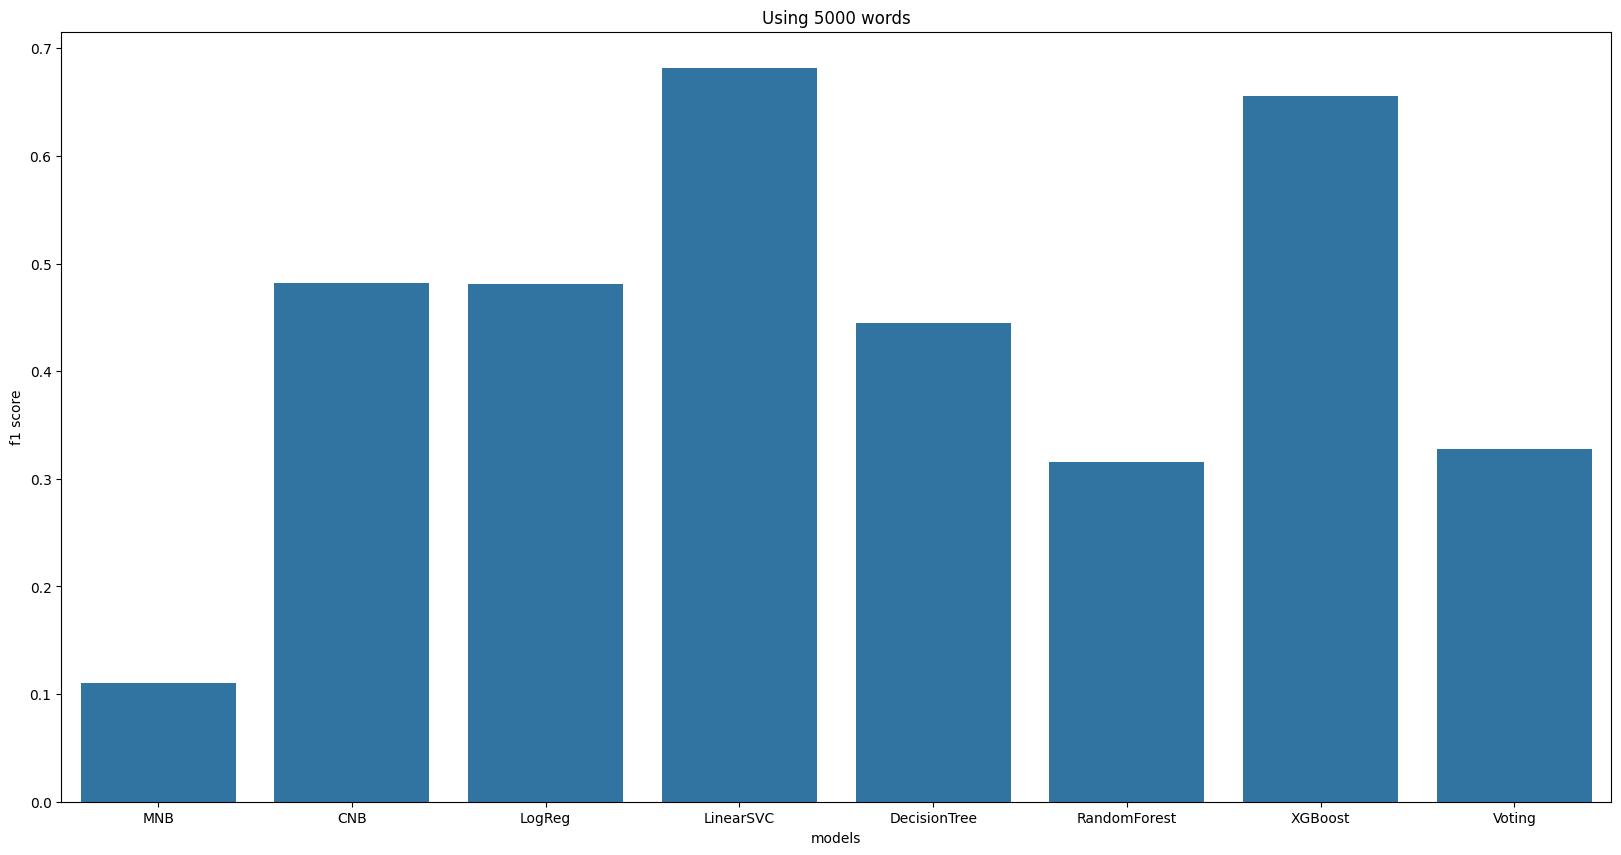

In [26]:
plt.figure(figsize=(20,10))
sns.barplot(x=results_5000['model'].values, y=results_5000['f1'].values)
plt.title('Using 5000 words')
plt.xlabel('models')
plt.ylabel('f1 score')
plt.show()


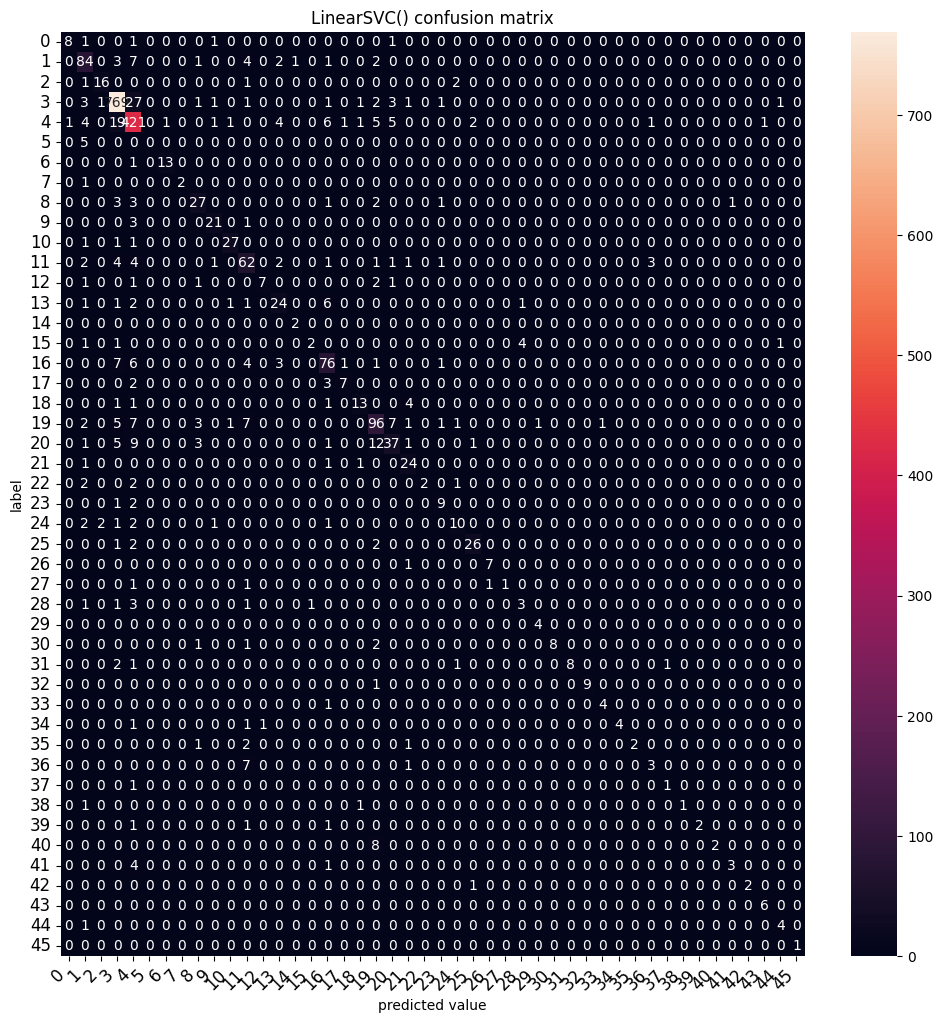

In [38]:
graph_confusion_matrix(models_dict['LinearSVC'], tfidfv_test, y_test)

# Using 15000 words

In [29]:
(x_train, y_train), (x_test, y_test)= reuters.load_data(num_words=15000, test_split=0.2)


In [30]:
index_to_word={index+3:word for word, index in word_index.items()}

for index, token in enumerate(('<pad>','<sos>','<unk>')):
  index_to_word[index]=token

In [31]:
decoded=[]
for i in range(len(x_train)):
  t=' '.join([index_to_word[index] for index in x_train[i]])
  decoded.append(t)

x_train=decoded

In [32]:
decoded=[]
for i in range(len(x_test)):
  t=' '.join([index_to_word[index] for index in x_test[i]])
  decoded.append(t)

x_test=decoded

In [33]:
dtmvector= CountVectorizer()
x_train_dtm=dtmvector.fit_transform(x_train)
tfidf_transformer=TfidfTransformer()
tfidfv=tfidf_transformer.fit_transform(x_train_dtm)
x_test_dtm = dtmvector.transform(x_test)
tfidfv_test = tfidf_transformer.transform(x_test_dtm)

In [34]:
from sklearn.metrics import f1_score, accuracy_score
results=[]
for name, model in models_dict.items():
  model.fit(tfidfv, y_train)
  predicted=model.predict(tfidfv_test)

  acc=accuracy_score(y_test, predicted)
  f1=f1_score(y_test, predicted, average='macro')

  results.append({'model': name, 'accuracy': acc, 'f1': f1})
  print(f'{name} Accuracy: {acc:.3f}, F1: {f1:.3f}')

MNB Accuracy: 0.633, F1: 0.085
CNB Accuracy: 0.772, F1: 0.467
LogReg Accuracy: 0.793, F1: 0.462
LinearSVC Accuracy: 0.828, F1: 0.684
DecisionTree Accuracy: 0.700, F1: 0.444
RandomForest Accuracy: 0.673, F1: 0.325


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [05:24:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Accuracy: 0.811, F1: 0.661
Voting Accuracy: 0.724, F1: 0.279


In [35]:
results_15000=pd.DataFrame(results)
results_15000

,model,accuracy,f1
0,MNB,0.633126,0.085341
1,CNB,0.772039,0.466771
2,LogReg,0.792965,0.462386
3,LinearSVC,0.828139,0.683982
4,DecisionTree,0.699911,0.444489
5,RandomForest,0.673197,0.324907
6,XGBoost,0.811220,0.661460
7,Voting,0.723954,0.278504


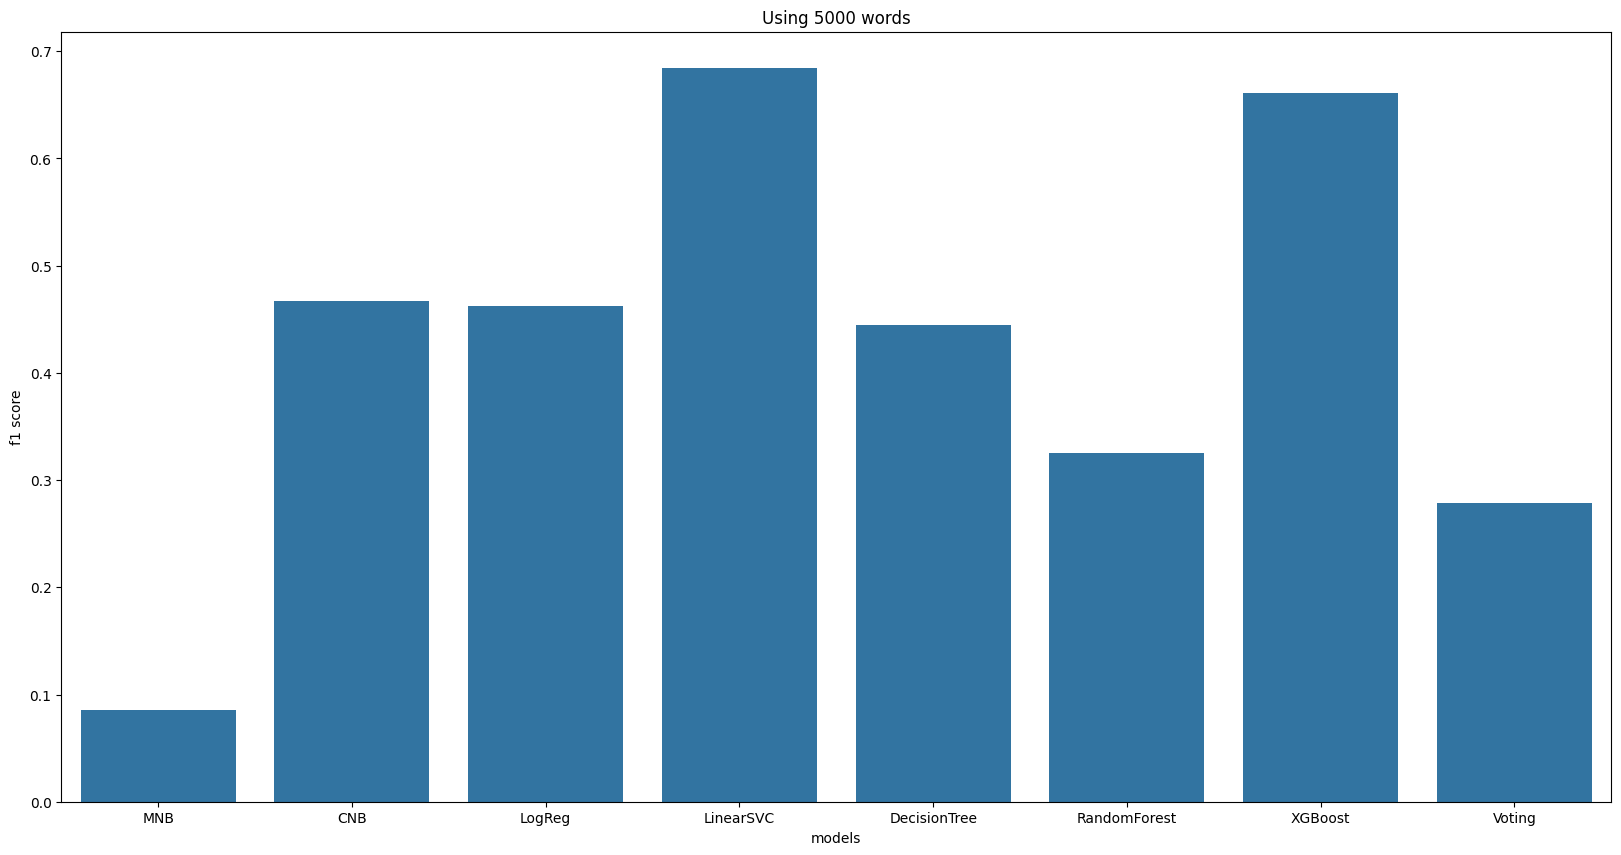

In [36]:
plt.figure(figsize=(20,10))
sns.barplot(x=results_15000['model'].values, y=results_15000['f1'].values)
plt.title('Using 15000 words')
plt.xlabel('models')
plt.ylabel('f1 score')
plt.show()


# RNN

In [43]:
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from sklearn.model_selection import train_test_split

device='cuda' if torch.cuda.is_available() else 'cpu'

(x_train_all, y_train_all), (x_test, y_test)= reuters.load_data(num_words=5000, test_split=0.2)
x_train, x_val, y_train, y_val=train_test_split(x_train_all, y_train_all, test_size=0.1, stratify=y_train_all)
vocab_size=5003
num_classes=int(max(y_train))+1

class ReutersDataset(Dataset):
  def __init__(self, seqs, labels):
    self.seqs=[torch.tensor(s, dtype=torch.long) for s in seqs]
    self.labels=torch.tensor(labels, dtype=torch.long)
  def __len__(self):
    return len(self.seqs)
  def __getitem__(self,i):
    return self.seqs[i], self.labels[i]

def collate_fn(batch):
  seqs,labels=zip(*batch)
  lengths=torch.tensor([len(s) for s in seqs])
  padded=pad_sequence(seqs, batch_first=True, padding_value=0)
  return padded, lengths, torch.tensor(labels)


batch_size=64
train_loader=DataLoader(ReutersDataset(x_train, y_train), batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader=DataLoader(ReutersDataset(x_val,y_val), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
test_loader=DataLoader(ReutersDataset(x_test, y_test), batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

class RNNClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, pad_idx=0):
    super().__init__()
    self.embedding=nn.Embedding(vocab_size, embedding_dim,padding_idx=pad_idx)
    self.rnn=nn.RNN(embedding_dim, hidden_dim, nonlinearity='tanh', batch_first=True)
    self.dropout=nn.Dropout(0.3)
    self.fc=nn.Linear(hidden_dim, num_classes)

  def forward(self,x, lengths):
    emb=self.embedding(x)
    packed=pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
    _,h_n=self.rnn(packed)
    h_last=h_n[-1]
    logits=self.fc(self.dropout(h_last))
    return logits


In [46]:
embedding_dim=128
hidden_dim=128
model=RNNClassifier(vocab_size, embedding_dim, hidden_dim, num_classes, pad_idx=0).to(device)
criterion=nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.Adam(model.parameters(), lr=1e-3)

def run_epoch(loader, train=True):
  model.train() if train else model.eval()
  total_loss, ys, yh=0, [], []
  with torch.set_grad_enabled(train):
    for X,L,y in loader:
      X,L,y=X.to(device), L.to(device), y.to(device)
      logits=model(X,L)
      loss=criterion(logits, y)

      if train:
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

      total_loss+=loss.item()*X.size(0)
      ys.append(y.detach().cpu())
      yh.append(logits.detach().cpu().argmax(dim=1))


    import torch as _t
    y_true = _t.cat(ys).numpy()
    y_pred = _t.cat(yh).numpy()
    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='macro', zero_division=0)
    return total_loss / len(loader.dataset), acc, f1


In [47]:

epochs = 10
for ep in range(1, epochs + 1):
    tr_loss, tr_acc, tr_f1 = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_f1 = run_epoch(val_loader,   train=False)
    print(f'E{ep:02d} | train: loss={tr_loss:.4f} acc={tr_acc:.3f} f1={tr_f1:.3f} '
          f'| val: loss={va_loss:.4f} acc={va_acc:.3f} f1={va_f1:.3f}')

te_loss, te_acc, te_f1 = run_epoch(test_loader, train=False)
print(f'TEST | loss={te_loss:.4f} acc={te_acc:.3f} f1={te_f1:.3f}')

E01 | train: loss=2.3895 acc=0.386 f1=0.021 | val: loss=2.1396 acc=0.461 f1=0.027
E02 | train: loss=2.0753 acc=0.481 f1=0.030 | val: loss=2.0835 acc=0.466 f1=0.026
E03 | train: loss=2.0023 acc=0.495 f1=0.040 | val: loss=1.9796 acc=0.501 f1=0.038
E04 | train: loss=1.8877 acc=0.525 f1=0.046 | val: loss=1.8654 acc=0.509 f1=0.043
E05 | train: loss=1.8222 acc=0.542 f1=0.050 | val: loss=1.8562 acc=0.521 f1=0.045
E06 | train: loss=1.7535 acc=0.558 f1=0.055 | val: loss=1.8020 acc=0.514 f1=0.049
E07 | train: loss=1.6987 acc=0.571 f1=0.057 | val: loss=1.8535 acc=0.494 f1=0.047
E08 | train: loss=1.6438 acc=0.590 f1=0.066 | val: loss=1.8163 acc=0.524 f1=0.052
E09 | train: loss=1.5713 acc=0.607 f1=0.073 | val: loss=1.8700 acc=0.507 f1=0.052
E10 | train: loss=1.5372 acc=0.614 f1=0.081 | val: loss=1.8321 acc=0.535 f1=0.053
TEST | loss=1.8462 acc=0.549 f1=0.066


In [48]:
epochs = 5
for ep in range(1, epochs + 1):
    tr_loss, tr_acc, tr_f1 = run_epoch(train_loader, train=True)
    va_loss, va_acc, va_f1 = run_epoch(val_loader,   train=False)
    print(f'E{ep:02d} | train: loss={tr_loss:.4f} acc={tr_acc:.3f} f1={tr_f1:.3f} '
          f'| val: loss={va_loss:.4f} acc={va_acc:.3f} f1={va_f1:.3f}')

te_loss, te_acc, te_f1 = run_epoch(test_loader, train=False)
print(f'TEST | loss={te_loss:.4f} acc={te_acc:.3f} f1={te_f1:.3f}')

E01 | train: loss=1.4576 acc=0.633 f1=0.091 | val: loss=1.8049 acc=0.548 f1=0.063
E02 | train: loss=1.3883 acc=0.652 f1=0.106 | val: loss=1.7907 acc=0.558 f1=0.079
E03 | train: loss=1.3203 acc=0.665 f1=0.130 | val: loss=1.8693 acc=0.537 f1=0.084
E04 | train: loss=1.2537 acc=0.677 f1=0.138 | val: loss=1.9354 acc=0.533 f1=0.087
E05 | train: loss=1.1973 acc=0.694 f1=0.161 | val: loss=1.9011 acc=0.560 f1=0.065
TEST | loss=1.9812 acc=0.556 f1=0.095


# 회고:

TF-IDF 모델 결과 요약

전체 어휘(26,506 특성)
결과적으로 MNB는 다른 모델들에 비해 크게 뒤처졌습니다(정확도 ≈0.60, F1≈0.07).
CNB와 로지스틱 회귀는 정확도 0.76–0.79, F1≈0.45–0.46 수준을 보였습니다.
가장 좋은 성능은 선형 SVC로, 정확도 ≈0.829, F1≈0.689였습니다.
XGBoost는 약간 낮아 정확도 ≈0.818, F1≈0.666을 기록했습니다.
결정트리와 랜덤 포레스트는 중간 성능(정확도 각각 ~0.70, 0.67), 보팅 앙상블은 약했습니다(F1≈0.26).

상위 5,000 단어만 사용
어휘를 제한하니 CNB와 로지스틱 회귀의 F1이 개선되었습니다. CNB는 정확도 ≈0.771, F1≈0.482에 도달했습니다.
선형 SVC와 XGBoost는 전체 어휘와 거의 동일한 성능으로 다시 선두를 차지했습니다:
SVC — 정확도 ≈0.829, F1≈0.681, XGBoost — 정확도 ≈0.814, F1≈0.655.
랜덤 포레스트와 보팅은 여전히 약했습니다.

15,000 단어 사용
어휘를 15,000으로 늘리면 CNB와 로지스틱 회귀의 성능이 다소 하락했고,
선형 SVC와 XGBoost는 기존 수준을 유지했습니다(F1 각각 ≈0.684, 0.661).
MNB는 다시 가장 약했습니다(F1≈0.085).
즉, 지나치게 큰 어휘는 잡음만 늘리고 품질 향상은 크지 않다는 뜻입니다.

모든 실험에서 **선형 SVC가 안정적으로 가장 높은 매크로 F1(≈0.68)**을 보였고, XGBoost가 그 다음이었습니다.
보완 나이브 베이즈(CNB)와 로지스틱 회귀는 무난하지만 SVC·XGBoost에는 미치지 못했습니다.
랜덤 포레스트, 단일 트리, 보팅 앙상블은 희소한 TF-IDF 특성에서는 효율이 낮았습니다.
Multinomial NB는 조건부 독립 가정과 클래스 불균형의 영향으로 성능이 크게 떨어졌습니다.

단순 RNN과의 비교

노트북 마지막에는 PyTorch로 임베딩 층 + 기본 RNN(tanh)을 구현했습니다.
단어 수 5,000, 10에폭 학습 후 테스트 정확도 ≈0.549, 매크로 F1≈0.066에 불과했습니다.
추가로 5에폭 더 학습해도 정확도는 0.556, F1은 ≈0.095로 낮았습니다.
이는 선형 SVC나 XGBoost보다 크게 떨어집니다.
숨은 차원 128의 단순 RNN은 Reuters처럼 길고 주제 수(다중 클래스)가 많은 텍스트를 잘 모델링하기 어렵기 때문이며,
더 강한 구조(LSTM/GRU, 1-D CNN, 트랜스포머)나 사전학습 임베딩이 필요합니다.

**결론**

TF-IDF + 선형 모델은 다중 뉴스 분류에서 간단하지만 매우 강력한 베이스라인이다.
선형 SVC가 모든 어휘 크기에서 정확도·F1 최고, XGBoost가 그 다음.

어휘 크기는 과하지 않게. 5,000 단어 제한은 CNB·로지스틱 회귀의 품질을 약간 개선.
15,000까지 늘려도 이득이 없거나 일부 모델은 F1이 악화.

순수 Multinomial NB는 약함. 대신 Complement NB나 로지스틱 회귀가 더 나은 출발점.

랜덤 포레스트·보팅 앙상블은 비효율적. 고차원 희소 TF-IDF엔 부적합.
XGBoost는 하이퍼파라미터 주의(예: GPU 학습 시 gpu_hist 대신 device="cuda" 사용).

단순 RNN은 고전적 모델에 크게 뒤짐. 신경망을 쓰려면 더 강한 구조나 사전학습 임베딩을 고려해야 함.